# 3D Object Reconstruction and Classification


## Colab Environment Setup

For the convenience of the submission and the evaluation, we created a repo for the dependencies and low level functions that are used in the notebook. We claim the [threed-comp](https://github.com/NerdToMars/threed-comp) repo is solely written by ourselves.

Before running this notebook, please run the following command to install the dependencies

In [2]:
# clone the repository and install the dependencies if in Colab
# Colab Setup - Only runs in Google Colab
try:
    import google.colab
    print("Running in Google Colab - setting up environment...")

    !uv pip install https://github.com/NerdToMars/threed-comp.git --system

    print("✓ Repository cloned and dependencies installed!")
    from google.colab import drive
    drive.mount('/content/drive')

except ImportError:
    print("Running locally - using existing environment")


Running in Google Colab - setting up environment...
Using Python 3.12.12 environment at: /usr
Resolved 145 packages in 1.55s
Audited 145 packages in 2ms
✓ Repository cloned and dependencies installed!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import threed_comp as tc
import threed_comp.utils as utils

from threed_comp.utils import load_mesh_from_relpath
from threed_comp.utils import mesh_to_voxel_feature
from threed_comp.utils import voxelize
from threed_comp.utils import display_voxel_grid
import urllib.request
import zipfile
from pathlib import Path
import os
import numpy as np
import trimesh
import rerun as rr
from threed_comp.utils import read_off
from threed_comp.utils import calculate_vertex_normals_trimesh

# Import necessary libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

from threed_comp.model import build_encoder, build_decoder, VAE
from threed_comp.model import L2_WEIGHT
import json
# check if the voxel file is already generated
VOXEL_SIZE = 64


tc.print_authors_info()


Authors:
HUANG chongtian, NTU, Singapore
ZHOU hanzhang, NTU, Singapore
Description: This project is a assignment project for course MA6514


## Dataset Description

[ModelNet10.zip](http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip) is a part of ModelNet40 dataset, containing 4,899 pre-aligned shapes from 10 categories. There are 3,991 (80%) shapes for training and 908 (20%) shapes for testing. The CAD models are in Object File Format (OFF).


We provide following scripts to Download and unzip the dataset (the dataset is few GBs, so it may take a while to download):

In [4]:
# download the dataset to ./datasets folder and unzip it


# Create datasets directory
datasets_dir = Path("datasets")
datasets_dir.mkdir(exist_ok=True)

# Download the dataset
dataset_url = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
zip_path = datasets_dir / "ModelNet10.zip"

# check if the dataset is already downloaded
if zip_path.exists():
    print(f"Dataset already downloaded to: {zip_path}")
else:
    print("Downloading ModelNet10 dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print(f"Downloaded to: {zip_path}")

# extract the dataset if not extracted
if not (datasets_dir / "ModelNet10").exists():
    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(datasets_dir)
    print("Extraction complete!")

    # List the contents to verify
    print("\nDataset contents:")
    for item in datasets_dir.iterdir():
        print(f"  {item.name}")

BASE_MODEL_DIR = datasets_dir / "ModelNet10"



print("Using BASE_MODEL_DIR: ", BASE_MODEL_DIR)

Dataset already downloaded to: datasets/ModelNet10.zip
Using BASE_MODEL_DIR:  datasets/ModelNet10


## Voxlized data

In [5]:

# Create datasets directory
datasets_dir = Path("datasets")
datasets_dir.mkdir(exist_ok=True)

# Download the dataset
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/tasadanluca/modelnet10-voxelized"
zip_path = datasets_dir / "ModelNet10_voxel.zip"

# check if the dataset is already downloaded
if zip_path.exists():
    print(f"Dataset already downloaded to: {zip_path}")
else:
    print("Downloading ModelNet10 voxeled dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print(f"Downloaded to: {zip_path}")

# extract the dataset if not extracted
if not (datasets_dir / "ModelNet10_Voxel").exists():
    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(datasets_dir/"ModelNet10_Voxel")
    print("Extraction complete!")

preprocessed_dir = datasets_dir / "ModelNet10_Voxel"

print("Using preprocessed_dir: ", preprocessed_dir)


Dataset already downloaded to: datasets/ModelNet10_voxel.zip
Using preprocessed_dir:  datasets/ModelNet10_Voxel


## Visualize the dataset

### Format of the 3D data in ModelNet10

Object File Format (.off) files are used to represent the geometry of a model by specifying the polygons of the model's surface. The polygons can have any number of vertices.
OFF files are all ASCII files beginning with the keyword OFF. The next line states the number of vertices, the number of faces, and the number of edges. The number of edges can be safely ignored.

The vertices are listed with x, y, z coordinates, written one per line. After the list of vertices, the faces are listed, with one face per line. For each face, the number of vertices is specified, followed by indices into the list of vertices. See the examples below.

Note that earlier versions of the model files had faces with -1 indices into the vertex list. That was due to an error in the conversion program and should be corrected now.
```
OFF numVertices numFaces numEdges
x y z
x y z
... numVertices like above
NVertices v1 v2 v3 ... vN
MVertices v1 v2 v3 ... vM
... numFaces like above

```
Note that vertices are numbered starting at 0 (not starting at 1), and that numEdges will always be zero.


We use [rerun](https://www.rerun.io/) to visualize the dataset. It might ask permission to download the wasm for interactive visualization.

### Metadata of the dataset

We walk through the BASE_MODEL_DIR and aggregate the folder structure of the dataset, the metadata is stored in the metadata_modelnet10.csv file. We commit the metadata_modelnet10.csv file to the [repository](https://github.com/NerdToMars/threed-comp) and included in the packageto avoid walking through the directories next time. Hence we can directly use the utils.get_modelnet10_metadata() function to get the metadata of the dataset.


In [6]:


# read the metadata of the dataset
metadata = utils.get_modelnet10_metadata()
print(metadata.head())

      object_id    class split                    object_path
0  bathtub_0107  bathtub  test  bathtub/test/bathtub_0107.off
1  bathtub_0108  bathtub  test  bathtub/test/bathtub_0108.off
2  bathtub_0109  bathtub  test  bathtub/test/bathtub_0109.off
3  bathtub_0110  bathtub  test  bathtub/test/bathtub_0110.off
4  bathtub_0111  bathtub  test  bathtub/test/bathtub_0111.off


In [9]:

# read a sample of the dataset
example_obj_path = os.path.join(BASE_MODEL_DIR, metadata.iloc[10]['object_path'])
verts, faces = read_off(example_obj_path)
print("verts.shape:", verts.shape)
print("faces.shape:", faces.shape)

# Calculate vertex normals using trimesh
vertex_normals = calculate_vertex_normals_trimesh(verts, faces)
print(vertex_normals.shape)

# Visualize the mesh with vertex normals using rerun
rr.init("rerun_notebook")

# rerun log mesh
rr.log("mesh", rr.Mesh3D(vertex_positions=verts, triangle_indices=faces, vertex_normals=vertex_normals, albedo_factor=[0.1, 0.5, 0.5]))

rr.notebook_show()


verts.shape: (6171, 3)
faces.shape: (7415, 3)
(4011, 3)


HTML(value='<div id="113657e1-e30a-4dc5-8380-60f36d06d39c"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

# Chapter 2: Exploratory Data Analysis (EDA)

In this chapter, we conduct a comprehensive exploratory data analysis of the ModelNet10 dataset to understand its characteristics, class distribution, and sample complexity variations. This analysis will inform our approach to 3D object reconstruction and classification.



In [7]:


# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the metadata
metadata = utils.get_modelnet10_metadata()
print("Dataset metadata loaded successfully!")
print(f"Total samples: {len(metadata)}")
print(f"Columns: {list(metadata.columns)}")
print("\nFirst few rows:")
print(metadata.head())


Dataset metadata loaded successfully!
Total samples: 4899
Columns: ['object_id', 'class', 'split', 'object_path']

First few rows:
      object_id    class split                    object_path
0  bathtub_0107  bathtub  test  bathtub/test/bathtub_0107.off
1  bathtub_0108  bathtub  test  bathtub/test/bathtub_0108.off
2  bathtub_0109  bathtub  test  bathtub/test/bathtub_0109.off
3  bathtub_0110  bathtub  test  bathtub/test/bathtub_0110.off
4  bathtub_0111  bathtub  test  bathtub/test/bathtub_0111.off


In [8]:
# 2.1 Dataset Overview
# Let's start by examining the basic characteristics of the ModelNet10 dataset.

# Basic dataset statistics
print("=" * 60)
print("MODELNET10 DATASET OVERVIEW")
print("=" * 60)

# Total samples
total_samples = len(metadata)
print(f"Total samples: {total_samples:,}")

# Number of categories
unique_classes = metadata['class'].unique()
num_categories = len(unique_classes)
print(f"Number of categories: {num_categories}")
print(f"Categories: {', '.join(sorted(unique_classes))}")

# Train/Test split
train_samples = len(metadata[metadata['split'] == 'train'])
test_samples = len(metadata[metadata['split'] == 'test'])
print(f"\nTrain/Test Split:")
print(f"  Training samples: {train_samples:,} ({train_samples/total_samples*100:.1f}%)")
print(f"  Test samples: {test_samples:,} ({test_samples/total_samples*100:.1f}%)")

# Samples per category
print(f"\nSamples per category:")
class_counts = metadata['class'].value_counts().sort_index()
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count:,} samples")

print("=" * 60)


MODELNET10 DATASET OVERVIEW
Total samples: 4,899
Number of categories: 10
Categories: bathtub, bed, chair, desk, dresser, monitor, night, sofa, table, toilet

Train/Test Split:
  Training samples: 3,991 (81.5%)
  Test samples: 908 (18.5%)

Samples per category:
  bathtub: 156 samples
  bed: 615 samples
  chair: 989 samples
  desk: 286 samples
  dresser: 286 samples
  monitor: 565 samples
  night: 286 samples
  sofa: 780 samples
  table: 492 samples
  toilet: 444 samples


## 2.2 Data Characteristics and Class Distribution Analysis

Now let's analyze the class distribution to understand if the dataset is balanced and examine the characteristics of each category.


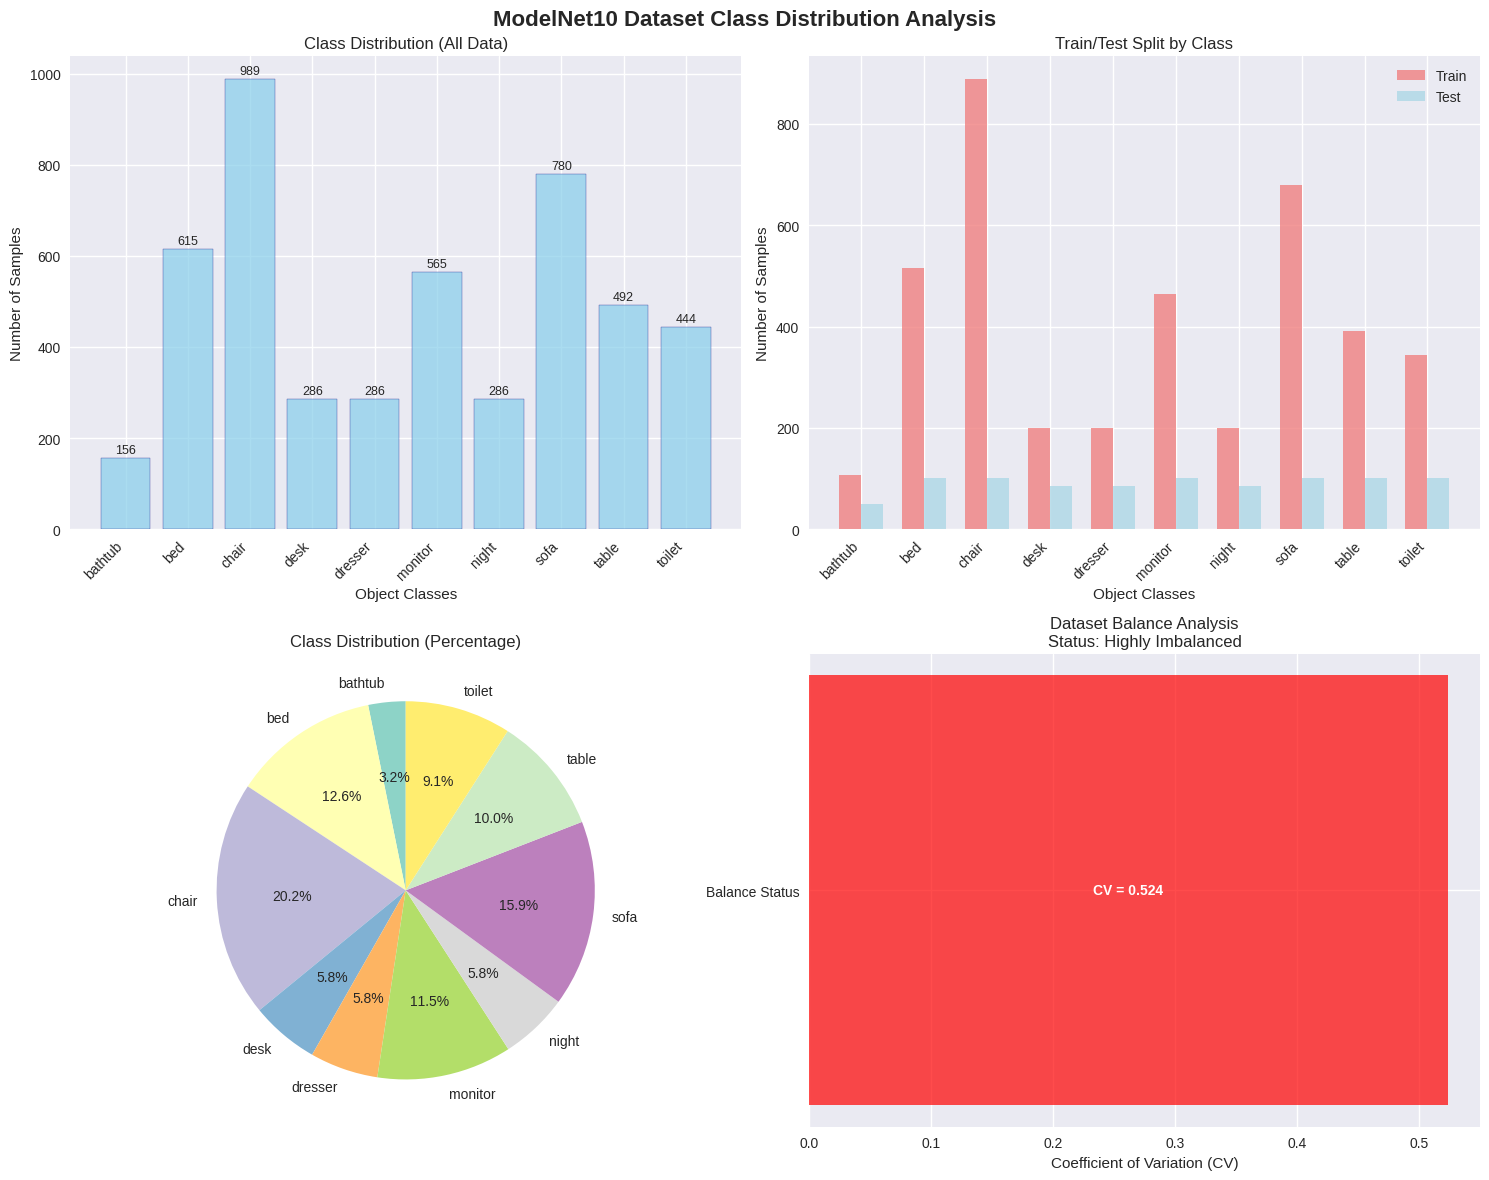


CLASS DISTRIBUTION BALANCE ANALYSIS
Mean samples per class: 489.9
Standard deviation: 256.7
Coefficient of variation: 0.524
Balance status: Highly Imbalanced
Min samples: 156
Max samples: 989
Range: 833


In [12]:
# 2.2 Class Distribution Analysis

# Create comprehensive class distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ModelNet10 Dataset Class Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Overall class distribution (bar plot)
class_counts = metadata['class'].value_counts().sort_index()
ax1 = axes[0, 0]
bars = ax1.bar(range(len(class_counts)), class_counts.values, color='skyblue', alpha=0.7, edgecolor='navy')
ax1.set_xlabel('Object Classes')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Class Distribution (All Data)')
ax1.set_xticks(range(len(class_counts)))
ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 2. Train/Test split by class
train_counts = metadata[metadata['split'] == 'train']['class'].value_counts().sort_index()
test_counts = metadata[metadata['split'] == 'test']['class'].value_counts().sort_index()

ax2 = axes[0, 1]
x = np.arange(len(class_counts))
width = 0.35

bars1 = ax2.bar(x - width/2, train_counts.values, width, label='Train', color='lightcoral', alpha=0.8)
bars2 = ax2.bar(x + width/2, test_counts.values, width, label='Test', color='lightblue', alpha=0.8)

ax2.set_xlabel('Object Classes')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Train/Test Split by Class')
ax2.set_xticks(x)
ax2.set_xticklabels(class_counts.index, rotation=45, ha='right')
ax2.legend()

# 3. Class distribution pie chart
ax3 = axes[1, 0]
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
wedges, texts, autotexts = ax3.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax3.set_title('Class Distribution (Percentage)')

# 4. Balance analysis
ax4 = axes[1, 1]
mean_samples = class_counts.mean()
std_samples = class_counts.std()
cv = std_samples / mean_samples  # Coefficient of variation

# Create balance indicator
balance_status = "Balanced" if cv < 0.2 else "Moderately Imbalanced" if cv < 0.5 else "Highly Imbalanced"
colors_balance = ['green' if cv < 0.2 else 'orange' if cv < 0.5 else 'red']

ax4.barh(['Balance Status'], [cv], color=colors_balance, alpha=0.7)
ax4.set_xlabel('Coefficient of Variation (CV)')
ax4.set_title(f'Dataset Balance Analysis\nStatus: {balance_status}')
ax4.text(cv/2, 0, f'CV = {cv:.3f}', ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Print detailed balance analysis
print("\n" + "="*60)
print("CLASS DISTRIBUTION BALANCE ANALYSIS")
print("="*60)
print(f"Mean samples per class: {mean_samples:.1f}")
print(f"Standard deviation: {std_samples:.1f}")
print(f"Coefficient of variation: {cv:.3f}")
print(f"Balance status: {balance_status}")
print(f"Min samples: {class_counts.min()}")
print(f"Max samples: {class_counts.max()}")
print(f"Range: {class_counts.max() - class_counts.min()}")
print("="*60)


## 2.3 Sample Complexity Analysis

Now let's analyze the complexity variations across different classes by examining geometric properties of the 3D objects.


In [13]:
# 2.3 Sample Complexity Analysis

def analyze_mesh_complexity(object_path):
    """
    Analyze the complexity of a 3D mesh by reading its geometric properties
    """
    try:
        verts, faces = read_off(object_path)

        # Basic geometric properties
        num_vertices = len(verts)
        num_faces = len(faces)

        # Calculate bounding box dimensions
        min_coords = verts.min(axis=0)
        max_coords = verts.max(axis=0)
        bbox_dims = max_coords - min_coords
        bbox_volume = np.prod(bbox_dims)

        # Calculate surface area (approximate)
        # For triangular meshes, we can calculate area of each triangle
        if len(faces) > 0 and faces.shape[1] == 3:
            # Get triangle vertices
            v0 = verts[faces[:, 0]]
            v1 = verts[faces[:, 1]]
            v2 = verts[faces[:, 2]]

            # Calculate cross products for area calculation
            cross_products = np.cross(v1 - v0, v2 - v0)
            triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)
            surface_area = np.sum(triangle_areas)
        else:
            surface_area = 0

        # Calculate aspect ratio (max dimension / min dimension)
        aspect_ratio = np.max(bbox_dims) / np.min(bbox_dims) if np.min(bbox_dims) > 0 else 1

        # Calculate vertex density (vertices per unit volume)
        vertex_density = num_vertices / bbox_volume if bbox_volume > 0 else 0

        return {
            'num_vertices': num_vertices,
            'num_faces': num_faces,
            'bbox_volume': bbox_volume,
            'surface_area': surface_area,
            'aspect_ratio': aspect_ratio,
            'vertex_density': vertex_density,
            'faces_per_vertex': num_faces / num_vertices if num_vertices > 0 else 0
        }
    except Exception as e:
        print(f"Error analyzing {object_path}: {e}")
        return None

# Sample a subset of objects from each class for complexity analysis
print("Analyzing sample complexity across classes...")
print("This may take a few minutes...")

complexity_data = []
sample_size_per_class = 20  # Sample 20 objects per class for analysis

for class_name in unique_classes:
    class_objects = metadata[metadata['class'] == class_name]
    sampled_objects = class_objects.sample(n=min(sample_size_per_class, len(class_objects)), random_state=42)

    print(f"Analyzing {len(sampled_objects)} samples from class '{class_name}'...")

    for _, obj in sampled_objects.iterrows():
        object_full_path = os.path.join(BASE_MODEL_DIR, obj['object_path'])
        complexity = analyze_mesh_complexity(object_full_path)
        if complexity:
            complexity['class'] = class_name
            complexity['object_id'] = obj['object_id']
            complexity_data.append(complexity)

# Convert to DataFrame
complexity_df = pd.DataFrame(complexity_data)
print(f"\nSuccessfully analyzed {len(complexity_df)} objects")
print(f"Classes analyzed: {complexity_df['class'].unique()}")


Analyzing sample complexity across classes...
This may take a few minutes...
Analyzing 20 samples from class 'bathtub'...
Analyzing 20 samples from class 'bed'...
Analyzing 20 samples from class 'chair'...
Analyzing 20 samples from class 'desk'...
Analyzing 20 samples from class 'dresser'...
Analyzing 20 samples from class 'monitor'...
Analyzing 20 samples from class 'night'...
Analyzing 20 samples from class 'sofa'...
Analyzing 20 samples from class 'table'...
Analyzing 20 samples from class 'toilet'...

Successfully analyzed 200 objects
Classes analyzed: ['bathtub' 'bed' 'chair' 'desk' 'dresser' 'monitor' 'night' 'sofa' 'table'
 'toilet']


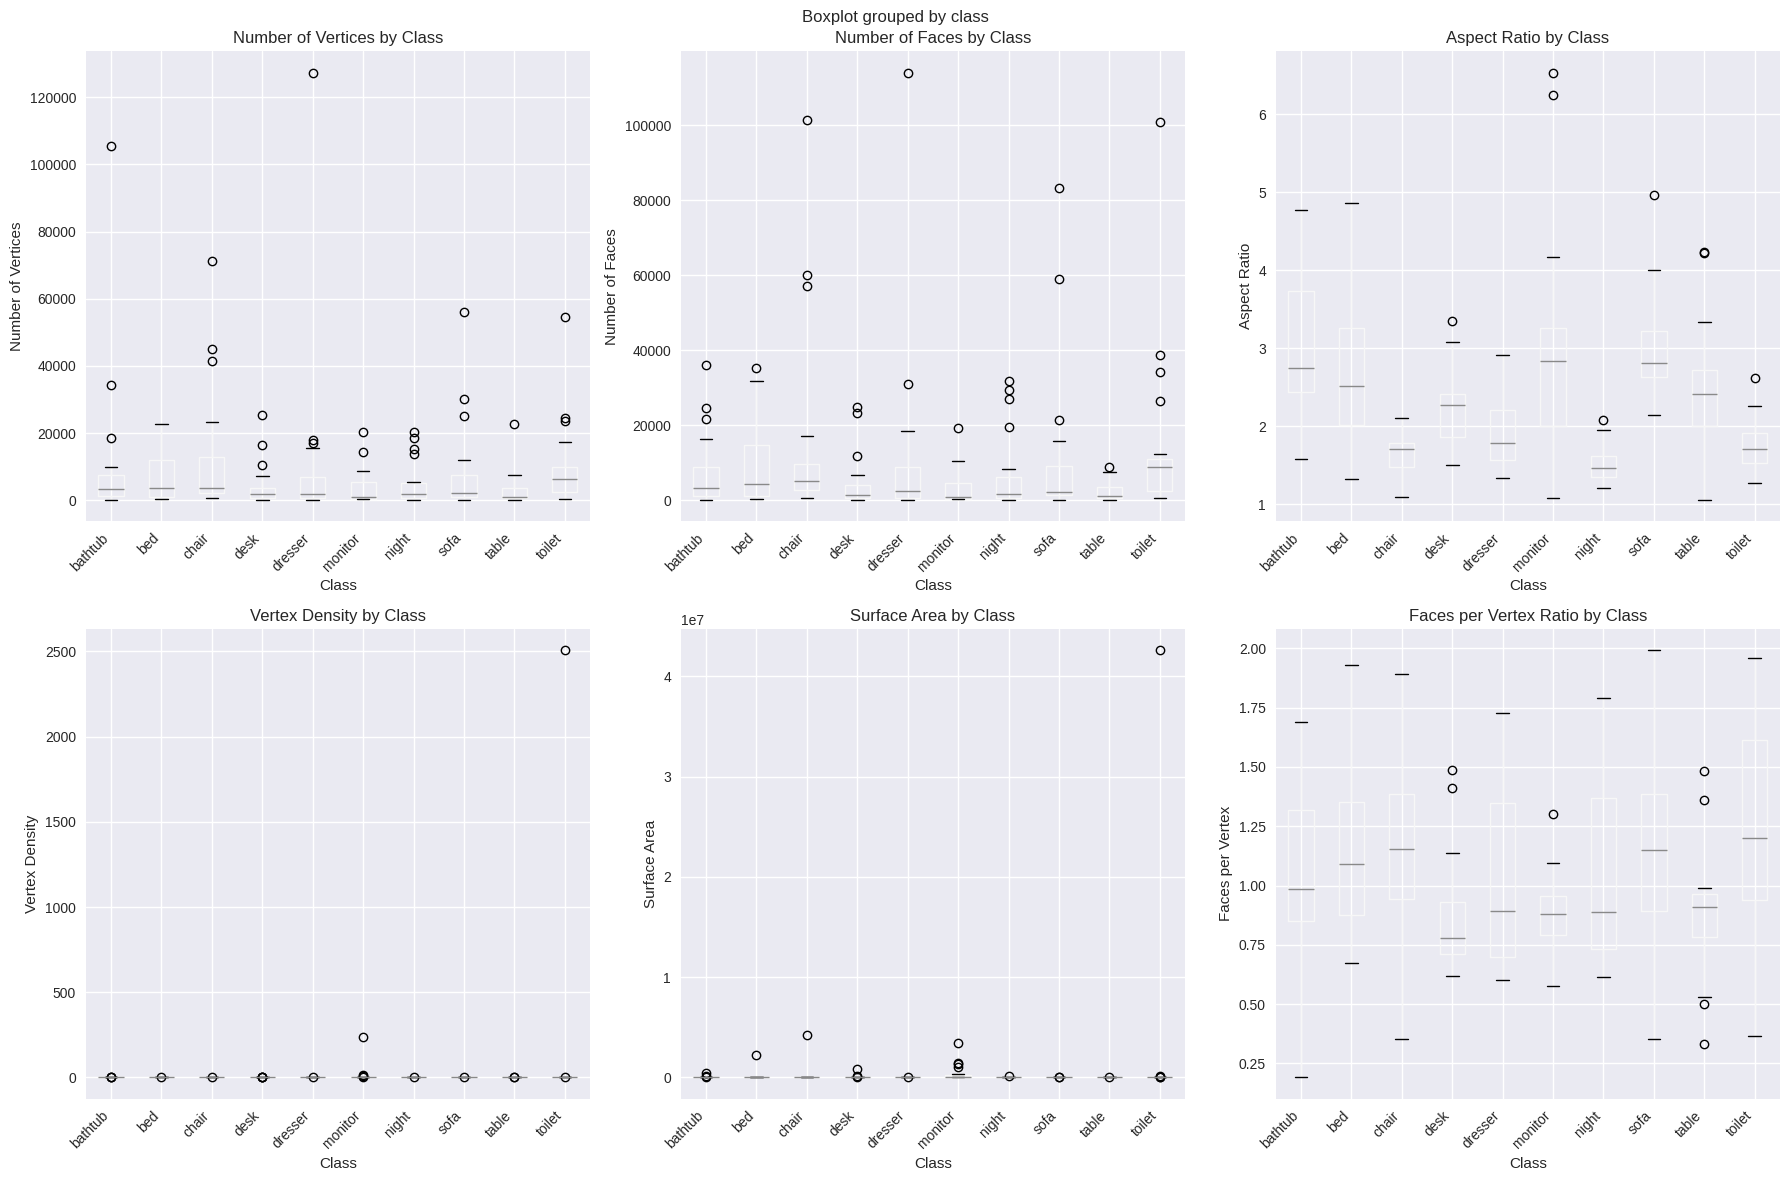


COMPLEXITY ANALYSIS SUMMARY
Complexity Statistics by Class:
        num_vertices                        num_faces                         \
                mean       std  min     max      mean       std  min     max   
class                                                                          
bathtub     10906.70  23651.27  216  105489   7508.90   9850.43  183   36080   
bed          6961.15   6831.59  312   22627   9562.05  11097.42  238   35299   
chair       12636.85  18882.47  742   71384  15372.40  26430.92  654  101583   
desk         4331.35   6382.72  188   25347   4524.25   7270.35  130   24877   
dresser     10775.35  28069.07  200  127322  11302.00  25578.83  128  114079   
monitor      3774.60   5425.20  273   20237   3443.30   4978.38  217   19278   
night        4889.80   6524.34  104   20394   7020.70  10668.89   64   31848   
sofa         8382.75  13948.53  128   56135  11378.10  21556.10  152   83342   
table        3256.35   5182.23  153   22740   2432.65   282

In [15]:
# Visualize complexity analysis results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('3D Object Complexity Analysis by Class', fontsize=16, fontweight='bold')

# 1. Number of vertices by class
ax1 = axes[0, 0]
complexity_df.boxplot(column='num_vertices', by='class', ax=ax1)
ax1.set_title('Number of Vertices by Class')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Vertices')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Number of faces by class
ax2 = axes[0, 1]
complexity_df.boxplot(column='num_faces', by='class', ax=ax2)
ax2.set_title('Number of Faces by Class')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Faces')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Aspect ratio by class
ax3 = axes[0, 2]
complexity_df.boxplot(column='aspect_ratio', by='class', ax=ax3)
ax3.set_title('Aspect Ratio by Class')
ax3.set_xlabel('Class')
ax3.set_ylabel('Aspect Ratio')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Vertex density by class
ax4 = axes[1, 0]
complexity_df.boxplot(column='vertex_density', by='class', ax=ax4)
ax4.set_title('Vertex Density by Class')
ax4.set_xlabel('Class')
ax4.set_ylabel('Vertex Density')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# 5. Surface area by class
ax5 = axes[1, 1]
complexity_df.boxplot(column='surface_area', by='class', ax=ax5)
ax5.set_title('Surface Area by Class')
ax5.set_xlabel('Class')
ax5.set_ylabel('Surface Area')
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

# 6. Faces per vertex ratio by class
ax6 = axes[1, 2]
complexity_df.boxplot(column='faces_per_vertex', by='class', ax=ax6)
ax6.set_title('Faces per Vertex Ratio by Class')
ax6.set_xlabel('Class')
ax6.set_ylabel('Faces per Vertex')
plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print complexity statistics
print("\n" + "="*80)
print("COMPLEXITY ANALYSIS SUMMARY")
print("="*80)

complexity_stats = complexity_df.groupby('class').agg({
    'num_vertices': ['mean', 'std', 'min', 'max'],
    'num_faces': ['mean', 'std', 'min', 'max'],
    'aspect_ratio': ['mean', 'std', 'min', 'max'],
    'vertex_density': ['mean', 'std', 'min', 'max'],
    'surface_area': ['mean', 'std', 'min', 'max']
}).round(2)

print("Complexity Statistics by Class:")
print(complexity_stats)

# Find most and least complex classes
print(f"\nMost complex class (by avg vertices): {complexity_df.groupby('class')['num_vertices'].mean().idxmax()}")
print(f"Least complex class (by avg vertices): {complexity_df.groupby('class')['num_vertices'].mean().idxmin()}")
print(f"Most elongated class (by avg aspect ratio): {complexity_df.groupby('class')['aspect_ratio'].mean().idxmax()}")
print(f"Most compact class (by avg aspect ratio): {complexity_df.groupby('class')['aspect_ratio'].mean().idxmin()}")
print("="*80)


## 2.4 Clustering Analysis with different 3D representations

We perform clustering analysis with different 3D representations to understand the characteristics of the dataset. We use the following 3D representations: Voxel, Point Cloud.

### 2.4.1 Clustering Analysis with Voxel Representation

We first convert the 3D objects to voxel representation and then perform clustering analysis.


In [16]:


# Demo on a single example
_demo_full_path = os.path.join(BASE_MODEL_DIR, metadata.iloc[0]['object_path'])
_demo_mesh = load_mesh_from_relpath(_demo_full_path)
_demo_feat = mesh_to_voxel_feature(_demo_mesh, resolution=16)
voxel_grid = voxelize(_demo_mesh, 16)
display_voxel_grid(voxel_grid, resolution=16, method='rerun', title='Voxel Grid')




HTML(value='<div id="bc9c0707-f36c-4a96-b8ef-eab71b35f6d9"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

Extracting voxel features...
Voxel features reduced from 4096 to 165 dims
Voxel Clustering – Silhouette: 0.076, ARI vs classes: 0.313


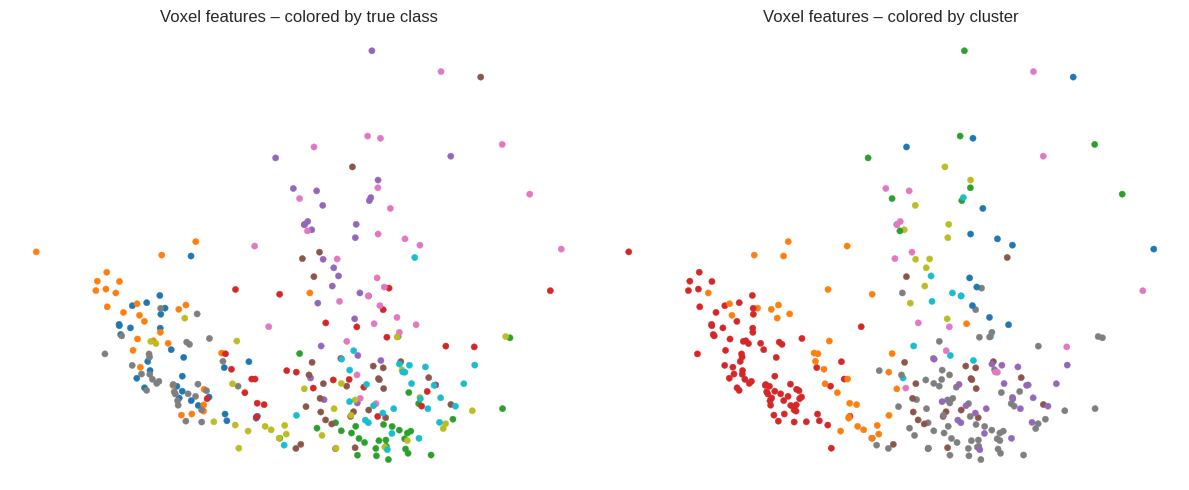

In [17]:
# 2.4.1 Clustering with Voxel Representation – experiment


# Build a small dataset of voxel features
samples_per_class = 30
sel = []
for c in sorted(unique_classes):
    cls_df = metadata[metadata['class'] == c].sample(n=min(samples_per_class, len(metadata[metadata['class']==c])), random_state=0)
    sel.append(cls_df)
sel_df = pd.concat(sel, ignore_index=True)

X_vox = []
y_true = []
print("Extracting voxel features...")
for _, row in sel_df.iterrows():
    object_full_path = os.path.join(BASE_MODEL_DIR, row['object_path'])
    mesh = load_mesh_from_relpath(object_full_path)
    feat = mesh_to_voxel_feature(mesh, resolution=16)
    X_vox.append(feat)
    y_true.append(row['class'])
X_vox = np.array(X_vox)

# Dimensionality reduction before clustering (PCA keeps 95% variance)
pca_vox = PCA(n_components=0.95, random_state=0)
X_vox_red = pca_vox.fit_transform(X_vox)
print(f"Voxel features reduced from {X_vox.shape[1]} to {X_vox_red.shape[1]} dims")

# KMeans clustering
kmeans_vox = KMeans(n_clusters=num_categories, n_init=10, random_state=0)
clusters_vox = kmeans_vox.fit_predict(X_vox_red)

# Evaluation
label_to_int = {c:i for i,c in enumerate(sorted(unique_classes))}
y_true_int = np.array([label_to_int[c] for c in y_true])

sil_vox = silhouette_score(X_vox_red, clusters_vox)
ari_vox = adjusted_rand_score(y_true_int, clusters_vox)
print(f"Voxel Clustering – Silhouette: {sil_vox:.3f}, ARI vs classes: {ari_vox:.3f}")

# Visualization of clusters in 2D
pca2 = PCA(n_components=2, random_state=0)
X2 = pca2.fit_transform(X_vox_red)
fig, ax = plt.subplots(1,2, figsize=(12,5))
sc0 = ax[0].scatter(X2[:,0], X2[:,1], c=[label_to_int[c] for c in y_true], cmap='tab10', s=20)
ax[0].set_title('Voxel features – colored by true class')
ax[0].set_axis_off()
sc1 = ax[1].scatter(X2[:,0], X2[:,1], c=clusters_vox, cmap='tab10', s=20)
ax[1].set_title('Voxel features – colored by cluster')
ax[1].set_axis_off()
plt.tight_layout(); plt.show()


### 2.4.2 Clustering Analysis with Point Cloud Representation

We next convert meshes to point clouds and perform clustering using simple, rotation/scale-normalized features.


Extracting point-cloud features...


Point cloud features reduced to 20 dims
Point Cloud Clustering – Silhouette: 0.136, ARI vs classes: 0.162


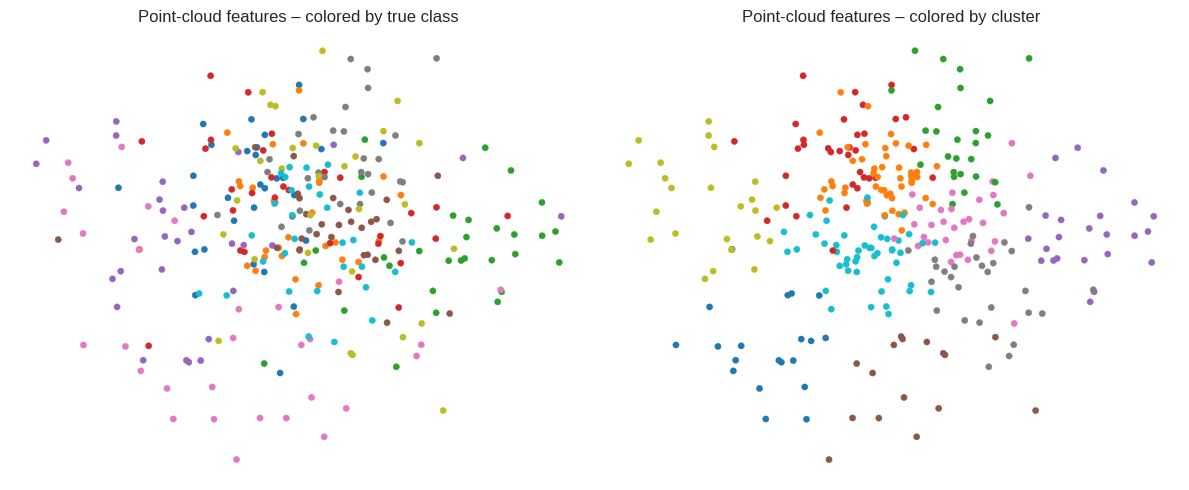

In [18]:
# 2.4.2 Clustering with Point Cloud Representation – helpers and experiment

from threed_comp.utils import mesh_to_point_cloud
from threed_comp.utils import point_cloud_features

# Build dataset
samples_per_class_pc = 30
sel_pc = []
for c in sorted(unique_classes):
    cls_df = metadata[metadata['class'] == c].sample(n=min(samples_per_class_pc, len(metadata[metadata['class']==c])), random_state=1)
    sel_pc.append(cls_df)
sel_df_pc = pd.concat(sel_pc, ignore_index=True)

X_pc = []
y_true_pc = []
print("Extracting point-cloud features...")
for _, row in sel_df_pc.iterrows():
    object_full_path = os.path.join(BASE_MODEL_DIR, row['object_path'])
    mesh = load_mesh_from_relpath(object_full_path)
    pts = mesh_to_point_cloud(mesh, n_points=1024)
    feat = point_cloud_features(pts, radial_bins=32)
    X_pc.append(feat)
    y_true_pc.append(row['class'])
X_pc = np.array(X_pc)

# Standardize and reduce
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_pc_std = scaler.fit_transform(X_pc)

pca_pc = PCA(n_components=0.95, random_state=0)
X_pc_red = pca_pc.fit_transform(X_pc_std)
print(f"Point cloud features reduced to {X_pc_red.shape[1]} dims")

kmeans_pc = KMeans(n_clusters=num_categories, n_init=10, random_state=0)
clusters_pc = kmeans_pc.fit_predict(X_pc_red)

label_to_int_pc = {c:i for i,c in enumerate(sorted(unique_classes))}
y_true_int_pc = np.array([label_to_int_pc[c] for c in y_true_pc])

sil_pc = silhouette_score(X_pc_red, clusters_pc)
ari_pc = adjusted_rand_score(y_true_int_pc, clusters_pc)
print(f"Point Cloud Clustering – Silhouette: {sil_pc:.3f}, ARI vs classes: {ari_pc:.3f}")

# 2D visualization
pca2_pc = PCA(n_components=2, random_state=0)
X2_pc = pca2_pc.fit_transform(X_pc_red)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(X2_pc[:,0], X2_pc[:,1], c=[label_to_int_pc[c] for c in y_true_pc], cmap='tab10', s=20)
ax[0].set_title('Point-cloud features – colored by true class'); ax[0].set_axis_off()
ax[1].scatter(X2_pc[:,0], X2_pc[:,1], c=clusters_pc, cmap='tab10', s=20)
ax[1].set_title('Point-cloud features – colored by cluster'); ax[1].set_axis_off()
plt.tight_layout(); plt.show()


In [19]:
# 2.4.3 Summary comparison between voxel and point-cloud clustering

print("="*80)
print("CLUSTERING SUMMARY – VOXEL vs POINT CLOUD")
print("="*80)
print(f"Voxel:    Silhouette = {sil_vox:.3f}, ARI = {ari_vox:.3f}")
print(f"PointCloud: Silhouette = {sil_pc:.3f}, ARI = {ari_pc:.3f}")

better = 'Voxel' if ari_vox >= ari_pc else 'PointCloud'
print(f"\nBetter alignment with categories (by ARI): {better}")
print("="*80)


CLUSTERING SUMMARY – VOXEL vs POINT CLOUD
Voxel:    Silhouette = 0.076, ARI = 0.313
PointCloud: Silhouette = 0.136, ARI = 0.162

Better alignment with categories (by ARI): Voxel


## 2.5 Key Findings and Insights

Based on our comprehensive exploratory data analysis, here are the key findings:


In [ ]:
# 2.4 Key Findings and Insights

print("="*80)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("="*80)

print("\n1. DATASET OVERVIEW:")
print(f"   • ModelNet10 contains {total_samples:,} 3D objects across {num_categories} categories")
print(f"   • Standard 80/20 train-test split ({train_samples:,} train, {test_samples:,} test)")
print(f"   • All objects are in OFF (Object File Format) with triangular meshes")

print(f"\n2. CLASS DISTRIBUTION:")
print(f"   • Dataset balance status: {balance_status} (CV = {cv:.3f})")
print(f"   • Most represented class: {class_counts.idxmax()} ({class_counts.max()} samples)")
print(f"   • Least represented class: {class_counts.idxmin()} ({class_counts.min()} samples)")
print(f"   • Range: {class_counts.max() - class_counts.min()} samples")

print(f"\n3. COMPLEXITY VARIATIONS:")
if len(complexity_df) > 0:
    most_complex = complexity_df.groupby('class')['num_vertices'].mean().idxmax()
    least_complex = complexity_df.groupby('class')['num_vertices'].mean().idxmin()
    most_elongated = complexity_df.groupby('class')['aspect_ratio'].mean().idxmax()
    most_compact = complexity_df.groupby('class')['aspect_ratio'].mean().idxmin()

    print(f"   • Most geometrically complex: {most_complex}")
    print(f"   • Least geometrically complex: {least_complex}")
    print(f"   • Most elongated objects: {most_elongated}")
    print(f"   • Most compact objects: {most_compact}")

    # Calculate complexity variance
    vertex_variance = complexity_df.groupby('class')['num_vertices'].var().mean()
    print(f"   • Average complexity variance across classes: {vertex_variance:.0f}")

print("="*80)


KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW:
   • ModelNet10 contains 4,899 3D objects across 10 categories
   • Standard 80/20 train-test split (3,991 train, 908 test)
   • All objects are in OFF (Object File Format) with triangular meshes

2. CLASS DISTRIBUTION:
   • Dataset balance status: Highly Imbalanced (CV = 0.524)
   • Most represented class: chair (989 samples)
   • Least represented class: bathtub (156 samples)
   • Range: 833 samples

3. COMPLEXITY VARIATIONS:
   • Most geometrically complex: chair
   • Least geometrically complex: table
   • Most elongated objects: bathtub
   • Most compact objects: night
   • Average complexity variance across classes: 224550668


## 3. Model Implementation

The VAE's CNN-based encoder is first trained on the shape completion task. This forces the encoder to learn a meaningful, low-dimensional latent vector from only the partial input. This learned representation serves as our primary feature for the downstream classification task.



### 3.1 Dataset preparation

As we want to use Voxel as the input, we need to convert the 3D objects to voxel representation.

In [11]:

# obj_path_voxel_dict = {}

# voxel_data_json_path = os.path.join(BASE_MODEL_DIR, 'voxel_data.json')
# if not os.path.exists(voxel_data_json_path):
#     voxel_dir = os.path.join(BASE_MODEL_DIR, 'voxel')

#     if not os.path.exists(voxel_dir):
#         os.makedirs(voxel_dir)

#     # convert the 3D objects to voxel representation
#     for _, row in metadata.iterrows():
#         object_full_path = os.path.join(BASE_MODEL_DIR, row['object_path'])
#         mesh = load_mesh_from_relpath(object_full_path)
#         voxel_grid = voxelize(mesh, VOXEL_SIZE)
#         voxel_path = os.path.join(voxel_dir, f"{row['object_id']}.npy")
#         np.save(voxel_path, voxel_grid)
#         obj_path_voxel_dict[row['object_path']] = voxel_path

#     print(f"Generated {len(metadata)} voxel files in {voxel_dir}")
#     # save the obj_path_voxel_dict to a json file
#     with open(os.path.join(BASE_MODEL_DIR, 'obj_path_voxel_dict.json'), 'w') as f:
#         json.dump(obj_path_voxel_dict, f)
# else:
#     with open(os.path.join(BASE_MODEL_DIR, 'obj_path_voxel_dict.json'), 'r') as f:
#         obj_path_voxel_dict = json.load(f)

# visualize few data


Visualizing 3 classes with 4 samples each in voxel representation...


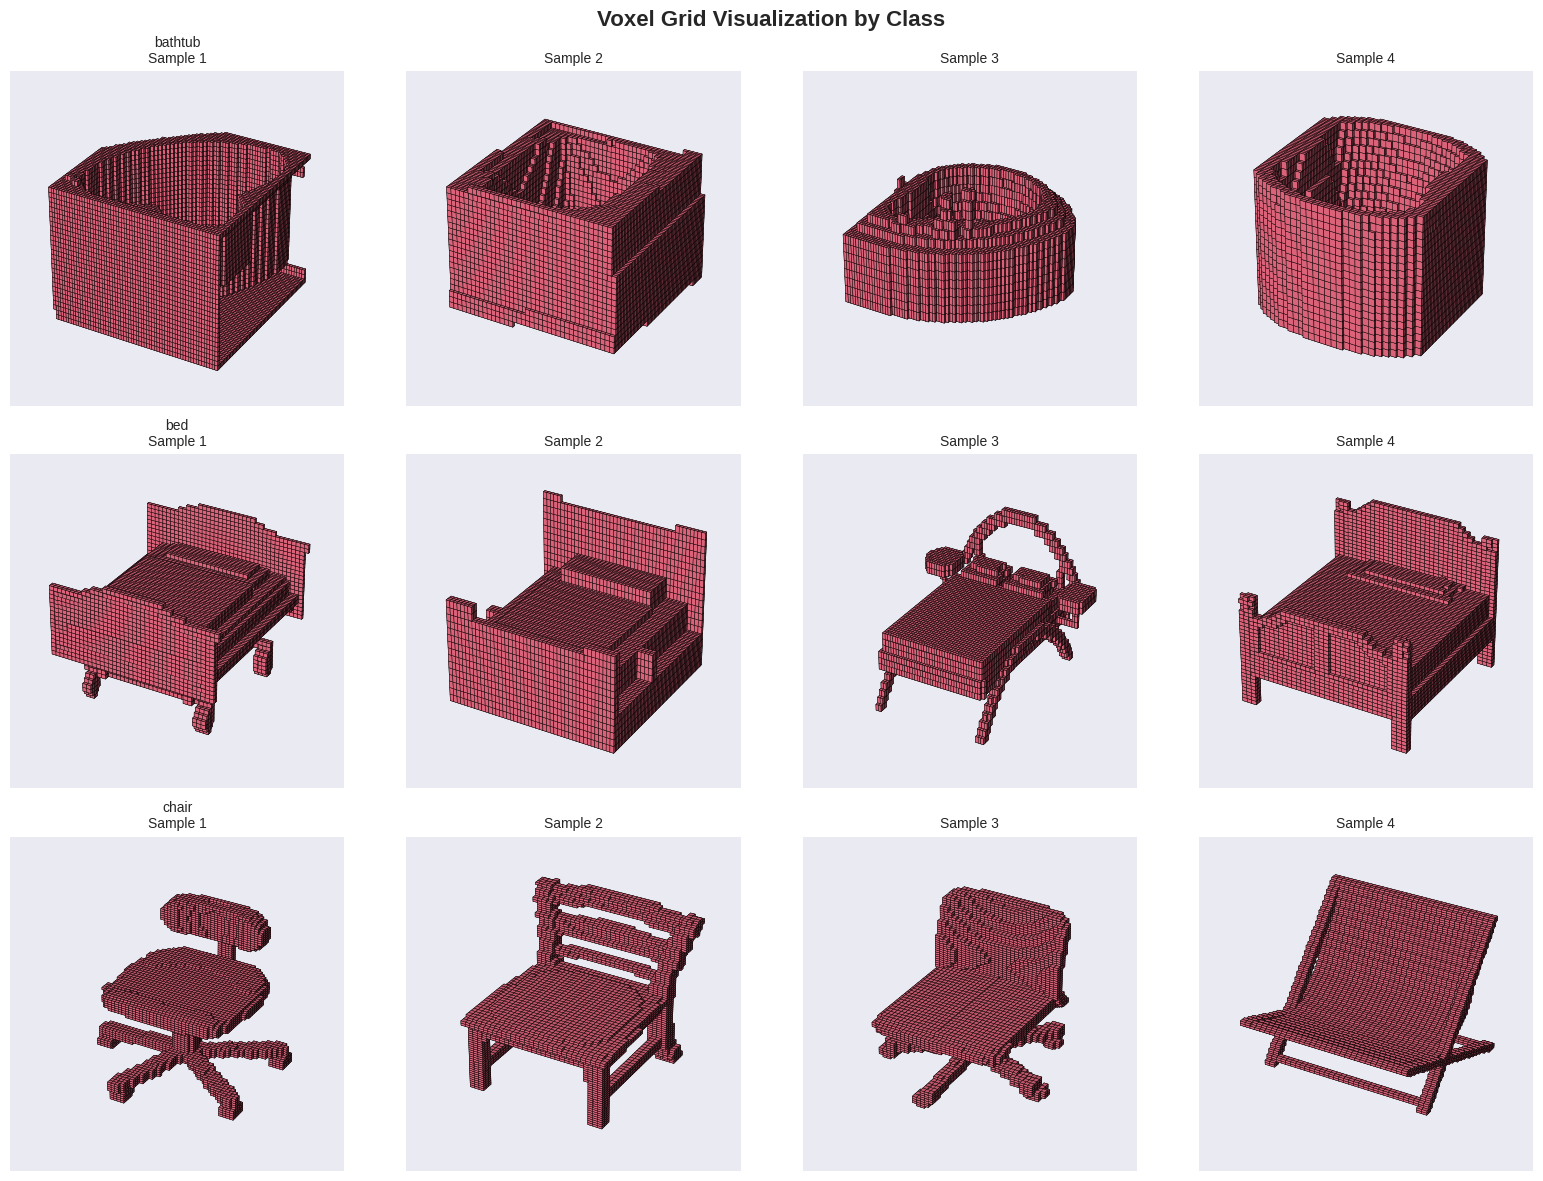

In [23]:

def plot_voxels_in_subplot(ax, voxel_grid, title="", threshold=0.6):
    """
    Plots a 3D voxel grid in a given subplot axis.
    """
    voxel_grid = np.squeeze(voxel_grid)

    # Use a threshold to convert the model's probabilistic output (0.0 to 1.0)
    # into a definite binary grid for clear plotting.
    binary_grid = voxel_grid > threshold

    # Use the ax.voxels() function to draw the grid
    ax.voxels(binary_grid, edgecolor='k')
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Select 3 classes and sample 4 objects from each
num_classes_to_show = 3
samples_per_class = 4

selected_classes = sorted(unique_classes)[:num_classes_to_show]
sampled_objects_by_class = []

for class_name in selected_classes:
    class_objects = metadata[metadata['class'] == class_name]
    sampled_objects = class_objects.sample(n=min(samples_per_class, len(class_objects)), random_state=42)
    sampled_objects_by_class.append((class_name, sampled_objects))

print(f"Visualizing {num_classes_to_show} classes with {samples_per_class} samples each in voxel representation...")

# Create the grid figure: 3 rows x 4 columns
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Voxel Grid Visualization by Class', fontsize=16, fontweight='bold')

# Load and plot voxel grids
for row_idx, (class_name, sampled_objects) in enumerate(sampled_objects_by_class):
    for col_idx, (_, row) in enumerate(sampled_objects.iterrows()):
        object_full_path = os.path.join(BASE_MODEL_DIR, row['object_path'])
        mesh = load_mesh_from_relpath(object_full_path)
        voxel_grid = voxelize(mesh, VOXEL_SIZE)

        # Calculate subplot index: row_idx * 4 + col_idx + 1 (1-indexed)
        ax = fig.add_subplot(num_classes_to_show, samples_per_class, row_idx * samples_per_class + col_idx + 1, projection='3d')

        # Use class name as title for first column, otherwise just column number
        if col_idx == 0:
            title = f"{class_name}\nSample {col_idx + 1}"
        else:
            title = f"Sample {col_idx + 1}"

        plot_voxels_in_subplot(ax, voxel_grid, title=title)

plt.tight_layout()
plt.show()

### 3.2 Model Details



In [24]:


latent_dim = 64
input_dim = (64,64,64,1)
reshape_dim = (8,8,8,-1)
encoder = build_encoder(input_dim, latent_dim, L2_WEIGHT)
decoder = build_decoder(latent_dim, reshape_dim, L2_WEIGHT)
vae = VAE(encoder,decoder, beta = 10)

encoder.summary()
print("\n\n")
decoder.summary()
print("\n")
vae.build(input_shape=(None, 64, 64, 64, 1))

vae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 16, 16,    │     55,360 │ batch_normalizat… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 8, 8, 8,   │    221,312 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │        512 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 8, 8,   │    442,496 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │        512 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 8, 8, 8,   │      8,320 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 8,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv3d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 16,777,472 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,540,160 (66.91 MB)

 Trainable params: 17,539,456 (66.91 MB)

 Non-trainable params: 704 (2.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     16,640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 65536)     │ 16,842,752 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 8,   │          0 │ dense_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 8, 8, 8,   │    442,496 │ reshape[0][0]     │
│ (Conv3DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │        512 │ conv3d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_1  │ (None, 16, 16,    │    442,496 │ batch_normalizat… │
│ (Conv3DTranspose)   │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv3d_transpose… │
│ (BatchNormalizatio… │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_2  │ (None, 16, 16,    │     16,512 │ reshape[0][0]     │
│ (Conv3DTranspose)   │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 16, 128)          │            │ conv3d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_3  │ (None, 32, 32,    │    221,248 │ add_1[0][0]       │
│ (Conv3DTranspose)   │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv3d_transpose… │
│ (BatchNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_4  │ (None, 64, 64,    │     55,328 │ batch_normalizat… │
│ (Conv3DTranspose)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv3d_transpose… │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_5  │ (None, 64, 64,    │        865 │ batch_normalizat… │
│ (Conv3DTranspose)   │ 64, 1)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,039,745 (68.82 MB)

 Trainable params: 18,039,041 (68.81 MB)

 Non-trainable params: 704 (2.75 KB)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 64), (None,    │    17,540,160 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 64, 1)  │    18,039,745 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,579,905 (135.73 MB)

 Trainable params: 35,578,497 (135.72 MB)

 Non-trainable params: 1,408 (5.50 KB)

### 3.3 Model Training setup

we split the dataset into test and train set with ratio 0.2 for test and 80% for training;

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


all_processed_files = os.listdir(preprocessed_dir)

categories = [f.split('_')[0] for f in all_processed_files]

train_processed, val_processed = train_test_split(
    all_processed_files,
    test_size=0.2,
    random_state=42,
    stratify = categories
)
train_full_paths = [os.path.join(preprocessed_dir, f) for f in train_processed]
val_full_paths = [os.path.join(preprocessed_dir, f) for f in val_processed]
print(len(val_full_paths))

799


In [19]:
import json

# Define the directory in Google Drive to save the files
drive_dir = '/content/drive/MyDrive/ModelNetVAE'

# Ensure the directory exists
os.makedirs(drive_dir, exist_ok=True)

# Define the file paths
train_paths_file = os.path.join(drive_dir, 'train_full_paths.json')
val_paths_file = os.path.join(drive_dir, 'val_full_paths.json')

# Dump the lists to JSON files
with open(train_paths_file, 'w') as f:
    json.dump(train_full_paths, f)

with open(val_paths_file, 'w') as f:
    json.dump(val_full_paths, f)

print(f"Train paths saved to: {train_paths_file}")
print(f"Validation paths saved to: {val_paths_file}")

Train paths saved to: /content/drive/MyDrive/ModelNetVAE/train_full_paths.json
Validation paths saved to: /content/drive/MyDrive/ModelNetVAE/val_full_paths.json


In [33]:
from threed_comp.datasets import VoxelizedDataset
from tensorflow.keras import layers
import keras

class PrintLR(keras.callbacks.Callback):
    """A custom callback to print the learning rate at the end of each epoch."""
    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer

        current_lr = optimizer.learning_rate

        if isinstance(current_lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            step = optimizer.iterations
            lr = current_lr(step)
            print(f" - LR: {lr.numpy():.7f}")
        else:
            print(f" - LR: {current_lr:.7f}")

import tensorflow as tf

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """A schedule that implements warmup and cosine decay."""
    def __init__(self, initial_learning_rate, warmup_steps, decay_steps, alpha=0.0):
        super(WarmupCosineDecay, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha

        self.cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            alpha=alpha
        )

    def __call__(self, step):
        with tf.name_scope("WarmupCosineDecay"):
            initial_learning_rate = tf.convert_to_tensor(self.initial_learning_rate, name="initial_learning_rate")

            return tf.cond(
                step < self.warmup_steps,
                # Warmup Phase: Linear increase
                lambda: (initial_learning_rate / self.warmup_steps) * step,
                # Decay Phase: Cosine decay
                lambda: self.cosine_decay(step - self.warmup_steps)
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
            "alpha": self.alpha,
        }


BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_WORKERS = os.cpu_count() - 1
WARMUP_EPOCHS = 10


train_generator = VoxelizedDataset(train_full_paths, batch_size=BATCH_SIZE, augment = True)
val_generator = VoxelizedDataset(val_full_paths, batch_size=BATCH_SIZE, augment = False)
print(len(val_generator))

steps_per_epoch = len(train_generator)
total_steps = NUM_EPOCHS * steps_per_epoch
warmup_steps = WARMUP_EPOCHS * steps_per_epoch
decay_steps = total_steps - warmup_steps

lr_schedule = WarmupCosineDecay(
    initial_learning_rate=0.01,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0.01
)

model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/ModelNetVAE/best_vae_model.weights.h5',
    save_weights_only=True,
    monitor='val_total_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_total_loss',
    patience=10,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

#vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-2, momentum=0.9, nesterov=True))
#vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0))
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9, nesterov = True, clipnorm = 1.0)
print_lr_callback = PrintLR()



24


### Training loop



In [61]:
print("Starting the training process")
vae.compile(optimizer = optimizer)
vae.load_weights('/content/drive/MyDrive/ModelNetVAE/best_vae_model.weights.h5')

history = vae.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback,
               early_stopping_callback,
              print_lr_callback]

)

print("Training finished!")


Starting the training process
Epoch 1/100
 8/99 ━━━━━━━━━━━━━━━━━━━━ 1:26 950ms/step - kl_loss: 47.8331 - loss: 4421.2853 - reconstruction_loss: 3942.9429

KeyboardInterrupt: 

In [57]:
history

In [52]:
import json

# Define the directory in Google Drive where history will be saved
drive_dir = '/content/drive/MyDrive/ModelNetVAE'


# Define the file path for the history JSON
history_file = os.path.join(drive_dir, 'training_history.json')

# Convert history object to a dictionary and dump to JSON
# The history.history attribute is already a dictionary
with open(history_file, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to: {history_file}")

Training history saved to: /content/drive/MyDrive/ModelNetVAE/training_history.json


Plotting training history...


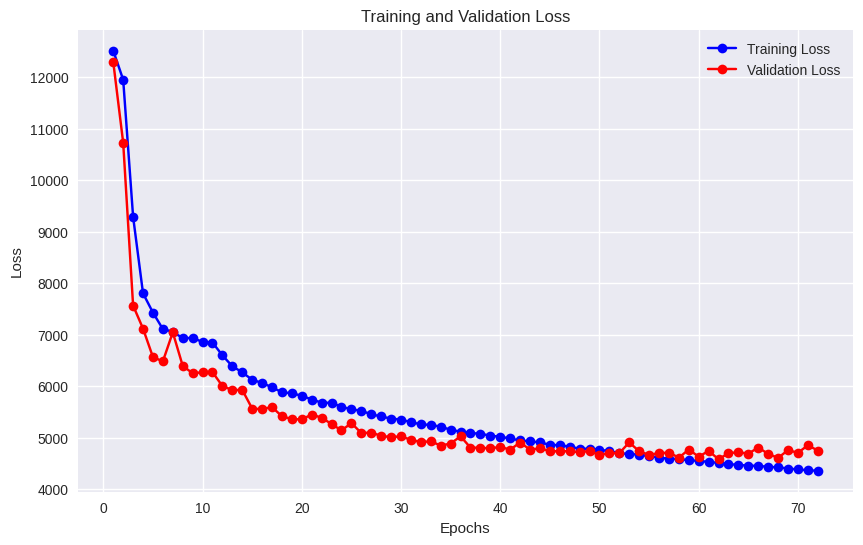

Plot displayed.


In [25]:
print("Plotting training history...")

loss = history.history['loss']
val_loss = history.history['val_total_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Plot displayed.")

In [51]:
print("Plotting KL Loss...")

kl_loss = history.history['kl_loss']
val_kl_loss = history.history['val_kl_loss']
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, kl_loss, 'bo-', label='Training KL Loss')
plt.plot(epochs, val_kl_loss, 'ro-', label='Validation KL Loss')
plt.title('Training and Validation KL Loss')
plt.xlabel('Epochs')
plt.ylabel('KL Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Plot displayed.")

Plotting KL Loss...
Plot displayed.


In [49]:
print("Keys available in the history object:")
print(history.history.keys())

# Check if 'lr' or 'learning_rate' is in the history keys
if 'lr' in history.history or 'learning_rate' in history.history:
    print("\nLearning rate is available in the history and can be plotted.")
elif 'LR' in history.history:
    print("\nLearning rate is available in the history with key 'LR' and can be plotted.")
else:
    print("\nLearning rate is not directly available in the history object for plotting.")
    print("However, the PrintLR callback was used, which prints the LR to stdout.")

Keys available in the history object:
dict_keys(['kl_loss', 'loss', 'reconstruction_loss', 'val_kl_loss', 'val_reconstruction_loss', 'val_total_loss'])

Learning rate is not directly available in the history object for plotting.
However, the PrintLR callback was used, which prints the LR to stdout.


In [50]:
print("Plotting Reconstruction Loss...")

reconstruction_loss = history.history['reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_loss']
epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, reconstruction_loss, 'bo-', label='Training Reconstruction Loss')
plt.plot(epochs, val_reconstruction_loss, 'ro-', label='Validation Reconstruction Loss')
plt.title('Training and Validation Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Plot displayed.")

Plotting Reconstruction Loss...
Plot displayed.


In [48]:
print("Plotting Reconstruction Loss...")

reconstruction_loss = history.history['reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_loss']
epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, reconstruction_loss, 'bo-', label='Training Reconstruction Loss')
plt.plot(epochs, val_reconstruction_loss, 'ro-', label='Validation Reconstruction Loss')
plt.title('Training and Validation Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Plot displayed.")

Plotting Reconstruction Loss...
Plot displayed.


In [42]:
len(val_reconstruction_loss)

72

## Test model



In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_voxels(voxel_grid, title="", threshold = 0.6):
    """
    Plots a 3D voxel grid from a NumPy array.
    """
    voxel_grid = np.squeeze(voxel_grid)

    # Use a threshold to convert the model's probabilistic output (0.0 to 1.0)
    # into a definite binary grid for clear plotting.
    binary_grid = voxel_grid > threshold

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Use the ax.voxels() function to draw the grid
    ax.voxels(binary_grid, edgecolor='k')

    ax.set_title(title)
    plt.show()

In [34]:
def calculate_reconstruction_similarity(originals, reconstructions, threshold=0.5):
    """
    Calculates the average Intersection over Union (IoU) similarity percentage.
    """
    # Binarize the voxel grids based on the threshold
    original_binary = tf.cast(originals > threshold, dtype=tf.float32)
    reconstructed_binary = tf.cast(reconstructions > threshold, dtype=tf.float32)

    original_flat = tf.reshape(original_binary, [original_binary.shape[0], -1])
    reconstructed_flat = tf.reshape(reconstructed_binary, [reconstructed_binary.shape[0], -1])

    # Calculate intersection and union
    intersection = tf.reduce_sum(original_flat * reconstructed_flat, axis=1)
    union = tf.reduce_sum(original_flat, axis=1) + tf.reduce_sum(reconstructed_flat, axis=1) - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)

    return tf.reduce_mean(iou) * 100

recreated_vae = VAE(encoder=encoder, decoder=decoder, beta = 10)

recreated_vae.build(input_shape=(None, 64, 64, 64, 1))

model_trained_now_file = '/kaggle/working/best_vae_model.weights.h5'
model_trained_previously = '/kaggle/input/previous-best-weights/best_vae_model.weights.h5'
model_trained_now_file = '/content/drive/MyDrive/ModelNetVAE/best_vae_model.weights.h5'


if os.path.exists(model_trained_now_file):
    recreated_vae.load_weights(model_trained_now_file)
    print("VAE weights from the model trained right now loaded successfully!")
else:
    recreated_vae.load_weights(model_trained_previously)
    print("VAE weights from previous model loaded successfully!")

recreated_vae.compile(optimizer = optimizer )




VAE weights from the model trained right now loaded successfully!


In [13]:
# Filter the metadata to get only the test samples
test_metadata = metadata[metadata['split'] == 'test']

# Get the list of object paths for the test samples
test_object_paths = test_metadata['object_path'].tolist()

print(f"Found {len(test_object_paths)} test samples.")
# print the first 5 test object paths
print("First 5 test object paths:")
for path in test_object_paths[:5]:
    print(path)


full_file_paths = test_object_paths
# random_model = np.expand_dims(np.load(full_file_paths[25]), axis=0) # Add batch dim
# random_model = np.expand_dims(random_model, axis=-1)

# load mesh from path
full_path = os.path.join(BASE_MODEL_DIR, full_file_paths[25])
mesh_model = load_mesh_from_relpath(full_path)
random_model = voxelize(mesh_model, VOXEL_SIZE)
plot_voxels(np.squeeze(random_model), title="Original Random Model")


Found 908 test samples.
First 5 test object paths:
bathtub/test/bathtub_0107.off
bathtub/test/bathtub_0108.off
bathtub/test/bathtub_0109.off
bathtub/test/bathtub_0110.off
bathtub/test/bathtub_0111.off


NameError: name 'plot_voxels' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


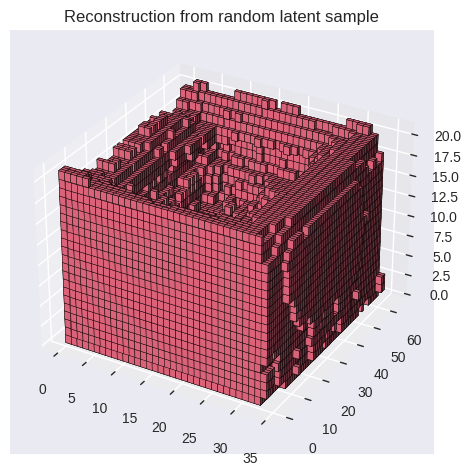

In [41]:
random_model = np.expand_dims(random_model, axis=0)
#z_random_mean = recreated_vae.encoder.predict(random_model)[0]
z_random = recreated_vae.encoder.predict(random_model)[0]

#plot_voxels(np.squeeze(z_random_mean), title="Mean of random object")
#plot_voxels(np.squeeze(z_random), title = "Sample of random object")

reconstructed_voxel_grid = recreated_vae.decoder.predict(z_random)
plot_voxels(np.squeeze(reconstructed_voxel_grid), title="Reconstruction from random latent sample", threshold = 0.9)

### Test with test dataset


In [16]:
import os
import numpy as np
from pathlib import Path

# Define the directory in Google Drive to save the voxel files
drive_voxel_dir = Path('/content/drive/MyDrive/ModelNetVAE/voxelized_test_dataset')

# Ensure the directory exists
drive_voxel_dir.mkdir(parents=True, exist_ok=True)

print(f"Converting and saving {len(test_object_paths)} test objects to voxel representation in {drive_voxel_dir}...")

saved_voxel_paths = []

for i, object_path in enumerate(test_object_paths):
    full_path = os.path.join(BASE_MODEL_DIR, object_path)
    # Extract the object_id from the object_path (e.g., 'bathtub/test/bathtub_0107.off' -> 'bathtub_0107')
    object_id = Path(object_path).stem # Use stem to get the filename without extension
    voxel_filename = f"{object_id}.npy"
    voxel_save_path = drive_voxel_dir / voxel_filename

    if voxel_save_path.exists():
        # Skip if already exists
        # print(f"Skipping {object_id}, already exists.")
        saved_voxel_paths.append(str(voxel_save_path))
        continue

    try:
        mesh = load_mesh_from_relpath(full_path)
        voxel_grid = voxelize(mesh, VOXEL_SIZE)

        np.save(voxel_save_path, voxel_grid)
        saved_voxel_paths.append(str(voxel_save_path))

        if (i + 1) % 100 == 0:
            print(f"Processed and saved {i + 1}/{len(test_object_paths)} objects")
    except Exception as e:
        print(f"Error processing {object_path}: {e}")


print("Voxel conversion and saving complete.")
print(f"Saved {len(saved_voxel_paths)} voxel files to {drive_voxel_dir}")

# You can optionally store the list of saved paths if needed later
# test_voxel_file_paths = saved_voxel_paths

Converting and saving 908 test objects to voxel representation in /content/drive/MyDrive/ModelNetVAE/voxelized_test_dataset...
Voxel conversion and saving complete.
Saved 908 voxel files to /content/drive/MyDrive/ModelNetVAE/voxelized_test_dataset


In [17]:
model_va = np.expand_dims(np.load(saved_voxel_paths[12]), axis=0) # Add batch dim
model_va.shape

(1, 64, 64, 64)

In [18]:

model_a = np.expand_dims(saved_voxel_paths[12], axis=0)
model_a = np.expand_dims(model_a, axis=-1) # Add channel dim



model_b = np.expand_dims(saved_voxel_paths[900], axis=0)
model_b = np.expand_dims(model_b, axis=-1)

# The encoder output is [z_mean, z_log_var, z].
z_a = recreated_vae.encoder.predict(model_a)[0]
z_b = recreated_vae.encoder.predict(model_b)[0]

num_steps = 10
interpolated_vectors = np.array([z_a + (z_b - z_a) * t for t in np.linspace(0, 1, num_steps)])
interpolated_vectors = np.squeeze(interpolated_vectors, axis=1) # Remove extra dimension

morphed_voxels = recreated_vae.decoder.predict(interpolated_vectors)


plot_voxels(np.squeeze(model_a), title="Original Object A")

# This loop shows the steps between the originals
for i in range(num_steps):
    plot_voxels(morphed_voxels[i], title=f"Morph Step {i+1}/{num_steps}", threshold = 0.75)

plot_voxels(np.squeeze(model_b), title="Original Object B")

NameError: name 'recreated_vae' is not defined

In [43]:
print(f"Model a: {full_file_paths[5]}")
print(f"Model b: {full_file_paths[27]}")

Model a: bathtub/test/bathtub_0112.off
Model b: bathtub/test/bathtub_0134.off


In [33]:
import numpy as np
import imageio
import os
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib


if not os.path.exists("morph_frames_ver1"):
    os.makedirs("morph_frames_ver1")

matplotlib.use('Agg')

def plot_and_save(voxel_grid, filename, title=""):
    voxel_grid = np.squeeze(voxel_grid)
    binary_grid = voxel_grid > 0.5
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.voxels(binary_grid, edgecolor='k')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.view_init(elev=20, azim=45)
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close(fig)

filenames = []

start_filename = "morph_frames_ver1/frame_00.png"
plot_and_save(np.squeeze(model_a), start_filename, title="Original Object A")
filenames.append(start_filename)

# Save each interpolated frame
num_steps = 10
for i in range(num_steps):
    frame_filename = f"morph_frames_ver1/frame_{i+1:02d}.png"
    plot_and_save(morphed_voxels[i], frame_filename, title=f"Morph Step {i+1}/{num_steps}")
    filenames.append(frame_filename)

end_filename = f"morph_frames_ver1/frame_{num_steps+1:02d}.png"
plot_and_save(np.squeeze(model_b), end_filename, title="Original Object B")
filenames.append(end_filename)
print("Creating GIF...")
with imageio.get_writer('voxel_morph2.gif', mode='I', duration=200) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print("GIF created successfully!")


Creating GIF...


/tmp/ipython-input-346724286.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created successfully!
